**This file explores the dataset**

I am starting with verifying the dimesnions of the dataset. I load the dataset using pandas' mmap_mode="r".

Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import interact, Dropdown, IntSlider
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for 3D plot support)
from matplotlib import cm  
import seaborn as sns
import pandas as pd


In [3]:
# Load raw IQ signals and metadata
dataset_path = '/Users/saurabhtiwari/Library/CloudStorage/OneDrive-TrinityCollege/Tinity/Summer 2025/RF Signal Classification/Dataset'
X = np.load(os.path.join(dataset_path, "signals.npy"), mmap_mode="r")     # shape: (N, 2, 1024)
y = np.load(os.path.join(dataset_path, "labels.npy"), mmap_mode="r")    # shape: (N, 24)
snr = np.load(os.path.join(dataset_path, "snrs.npy"), mmap_mode="r")      # shape: (N,)

# Check dimensions
print("X shape:", X.shape)       # Expect: (2555904, 2, 1024)
print("y shape:", y.shape)       # Expect: (2555904, 24)
print("SNR shape:", snr.shape)   # Expect: (2555904,)
print("SNRs:", np.unique(snr))

# Load modulation names
classes = np.load("classes.npy", allow_pickle=True).tolist()

print()
print("Modulation Classes: ", classes)
print(classes[0])



X shape: (2555904, 1024, 2)
y shape: (2555904, 24)
SNR shape: (2555904, 1)
SNRs: [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.]

Modulation Classes:  ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', '8ASK', 'BPSK', '8PSK', 'AM-SSB-SC', '4ASK', '16PSK', '64APSK', '128QAM', '128APSK', 'AM-DSB-SC', 'AM-SSB-WC', '64QAM', 'QPSK', '256QAM', 'AM-DSB-WC', 'OOK', '16QAM']
32PSK


**Next, I plot both I and Q on the same plot and then side by side**

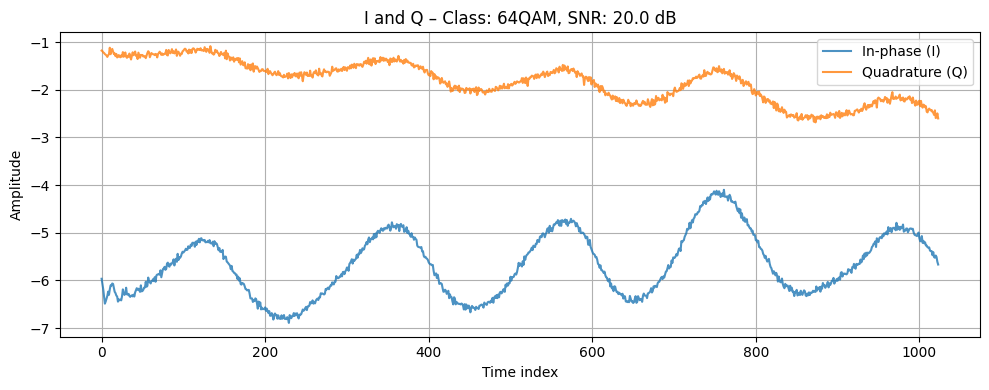

In [4]:
def plot_iq_single_plot(X, y, snr, classes, idx=None):
    if idx is None:
        idx = random.randint(0, len(X) - 1)

    i_data = X[idx, :, 0]
    q_data = X[idx, :, 1]
    label = classes[y[idx].argmax()]
    snr_val = snr[idx][0] if snr.ndim > 1 else snr[idx]

    plt.figure(figsize=(10, 4))
    plt.plot(i_data, label='In-phase (I)', alpha=0.8)
    plt.plot(q_data, label='Quadrature (Q)', alpha=0.8)
    plt.title(f"I and Q – Class: {label}, SNR: {snr_val} dB")
    plt.xlabel("Time index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_iq_single_plot(X, y, snr, classes, idx=2000001)

In [8]:
chunk_size = 125000  # each chunk has 125k samples
num_chunks = 19  # based on dataset size: 2555904 / 125000 ≈ 20.4
class_coverage_by_chunk = {}

for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(y))
    chunk_labels = y[start:end]
    present = np.unique(np.argmax(chunk_labels, axis=1))
    class_coverage_by_chunk[i] = present
    print(f"Chunk {i}: Classes {present}")


Chunk 0: Classes [0 1]
Chunk 1: Classes [1 2]
Chunk 2: Classes [2 3]
Chunk 3: Classes [3 4]
Chunk 4: Classes [4 5]
Chunk 5: Classes [5 6 7]
Chunk 6: Classes [7 8]
Chunk 7: Classes [8 9]
Chunk 8: Classes [ 9 10]
Chunk 9: Classes [10 11]
Chunk 10: Classes [11 12]
Chunk 11: Classes [12 13 14]
Chunk 12: Classes [14 15]
Chunk 13: Classes [15 16]
Chunk 14: Classes [16 17]
Chunk 15: Classes [17 18]
Chunk 16: Classes [18 19]
Chunk 17: Classes [19 20 21]
Chunk 18: Classes [21 22]


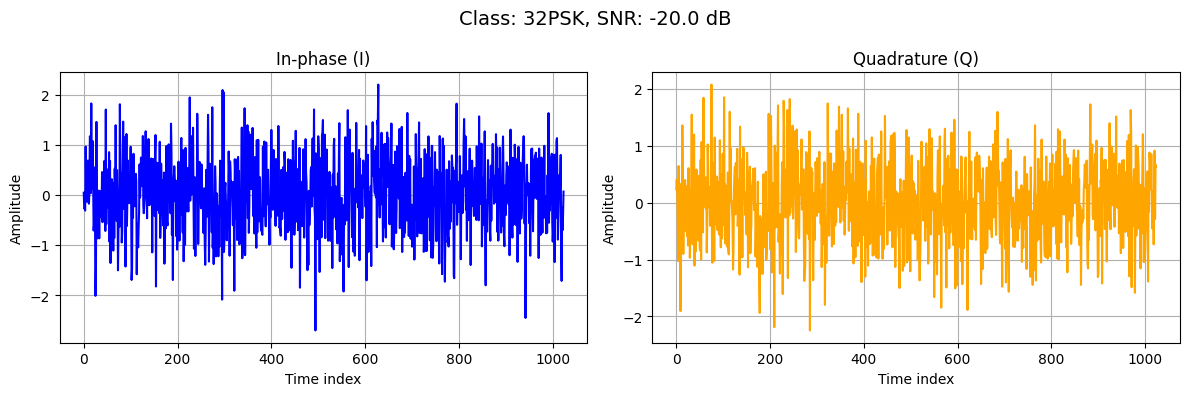

In [5]:
def plot_iq_subplots(X, y, snr, classes, idx=None):
    if idx is None:
        idx = random.randint(0, len(X) - 1)

    i_data = X[idx, :, 0]
    q_data = X[idx, :, 1]
    label = classes[y[idx].argmax()]
    snr_val = snr[idx][0] if snr.ndim > 1 else snr[idx]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(i_data, color='blue')
    axs[0].set_title("In-phase (I)")
    axs[0].set_xlabel("Time index")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)

    axs[1].plot(q_data, color='orange')
    axs[1].set_title("Quadrature (Q)")
    axs[1].set_xlabel("Time index")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid(True)

    fig.suptitle(f"Class: {label}, SNR: {snr_val} dB", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_iq_subplots(X, y, snr, classes, idx=0)

**Consetallation plots for I vs Q**

Since different modulation schemes have different constellation plots. They can be used to differentiate between various modulation schemes.

As SNR decreases:
- the points spread out
- clusters overlap
- symbols become indistinguishable

High SNR → tight clusters = low bit error rate. 
Low SNR → blurry, overlapping clouds = hard to decode

["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "256QAM"] --> These give a more distinct looking constellation

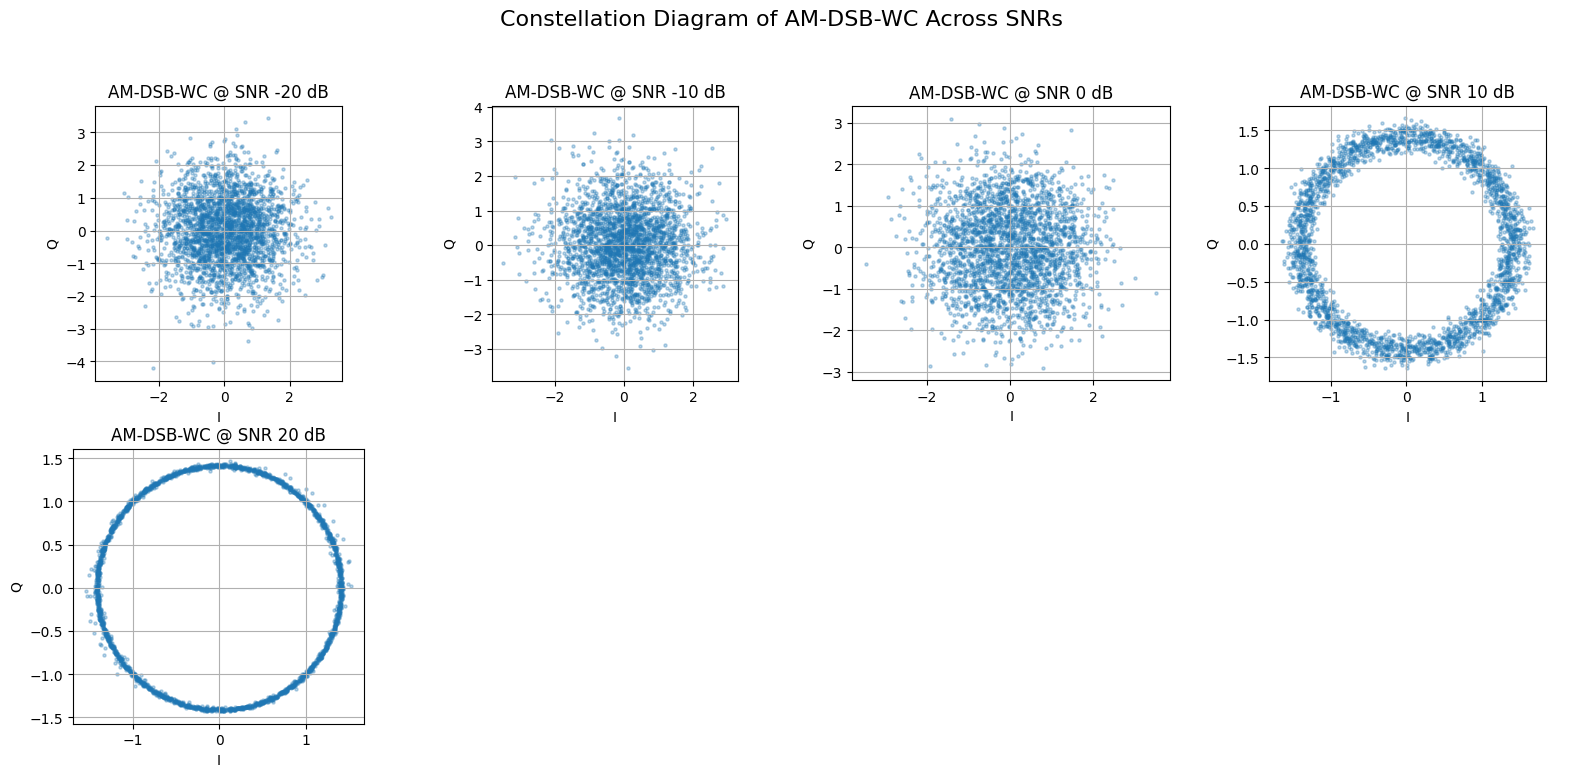

In [6]:
def plot_constellation_by_snr(
    X, y, snr, classes,
    target_class,
    snr_values=None,
    max_signals=10,            # how many signals to include per SNR
    max_points_per_signal=256, # how many I/Q points per signal
    marker_size=5,
    alpha=0.3
):
    # Find numeric index of the target modulation
    class_idx = classes.index(target_class)

    # Ensure SNR is a 1D array (remove shape issues like (N, 1))
    snr = np.squeeze(snr)

    # Default: use all unique SNRs in the dataset if none specified
    if snr_values is None:
        snr_values = sorted(np.unique(snr))

    # Set up subplot layout
    ncols = 4
    nrows = int(np.ceil(len(snr_values) / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, snr_val in enumerate(snr_values):
        # Find all sample indices that match both the class and the SNR
        indices = np.where((y.argmax(axis=1) == class_idx) & (snr == snr_val))[0]

        if len(indices) == 0:
            # If no matching samples, show message and skip
            axs[i].set_title(f"SNR {snr_val} dB\n(no samples)")
            axs[i].axis("off")
            continue

        # Randomly pick a few signals (max_signals)
        chosen = np.random.choice(indices, size=min(max_signals, len(indices)), replace=False)

        # Select a limited number of IQ points per signal (e.g., first 256)
        iq_samples = X[chosen, :max_points_per_signal, :]  # shape: (max_signals, max_points, 2)

        # Flatten all I and Q components into a single list of points
        I = iq_samples[:, :, 0].flatten()
        Q = iq_samples[:, :, 1].flatten()

        # Normalize (optional): helps if scales vary wildly
        I /= np.std(I)
        Q /= np.std(Q)

        # Scatter plot of I vs Q
        axs[i].scatter(I, Q, s=marker_size, alpha=alpha)
        axs[i].set_title(f"{target_class} @ SNR {snr_val} dB")
        axs[i].set_xlabel("I")
        axs[i].set_ylabel("Q")
        axs[i].set_aspect('equal')
        axs[i].grid(True)

    # Hide any leftover subplots if grid is too big
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Add a global title and show
    fig.suptitle(f"Constellation Diagram of {target_class} Across SNRs", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_constellation_by_snr(
    X, y, snr, classes,
    target_class="AM-DSB-WC",
    snr_values=[-20, -10, 0, 10, 20],
    max_signals=10,
    max_points_per_signal=256
)


In [11]:
%matplotlib notebook
%matplotlib inline


The below code block produces an interactive plot for constellation diagrams. It lets the user choose the SNR and the modulation type to display about 256 signals in that category.

In [ ]:

def interactive_constellation(X, y, snr, classes):
    # Clean SNR list
    snr_vals = sorted(np.unique(np.squeeze(snr)).astype(int))
    
    @interact(
        modulation=Dropdown(options=classes, description="Modulation:"),
        snr_db=Dropdown(options=snr_vals, description="SNR (dB):")
    )
    def update(modulation, snr_db):
        # Get class index
        class_idx = classes.index(modulation)
        snr_array = np.squeeze(snr)
        idxs = np.where((y.argmax(axis=1) == class_idx) & (snr_array == snr_db))[0]

        if len(idxs) == 0:
            print("No matching samples.")
            return

        # Select small subset for clarity
        chosen = np.random.choice(idxs, size=min(10, len(idxs)), replace=False)
        iq = X[chosen, :256, :]  # (10, 256, 2)

        I = iq[:, :, 0].flatten()
        Q = iq[:, :, 1].flatten()

        plt.figure(figsize=(5, 5))
        plt.scatter(I, Q, s=5, alpha=0.4)
        plt.title(f"{modulation} @ SNR {snr_db} dB")
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.grid(True)
        plt.show()
        
interactive_constellation(X, y, snr, classes)

interactive(children=(Dropdown(description='Modulation:', options=('32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '…

The following code produces and saves an GIF animation of the constellation diagram. The GIF loops through various SNRs for the modulation type that is passed to the function.

In [ ]:
def animate_constellation(X, y, snr, classes, modulation="QPSK", save=False):
    class_idx = classes.index(modulation)
    snr_array = np.squeeze(snr)
    snr_vals = sorted(np.unique(snr_array).astype(int))

    fig, ax = plt.subplots(figsize=(5, 5))
    scatter = ax.scatter([], [], s=2, alpha=0.4)
    title = ax.set_title("")

    def update(frame):
        snr_val = snr_vals[frame]
        idxs = np.where((y.argmax(axis=1) == class_idx) & (snr_array == snr_val))[0]
        if len(idxs) == 0:
            scatter.set_offsets([])
            title.set_text(f"No samples @ SNR {snr_val} dB")
            return scatter,

        chosen = np.random.choice(idxs, size=min(5, len(idxs)), replace=False)
        iq = X[chosen, :500, :]  # shape (5, 256, 2)
        I = iq[:, :, 0].flatten()
        Q = iq[:, :, 1].flatten()
        points = np.stack((I, Q), axis=1)
        scatter.set_offsets(points)
        title.set_text(f"{modulation} @ SNR {snr_val} dB")
        return scatter,

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    ax.grid(True)
    ax.set_aspect("equal")

    anim = FuncAnimation(fig, update, frames=len(snr_vals), interval=800, repeat=True)

    if save:
        gif_path = f"{modulation}_constellation.gif"
        print(f"Saving animation to {gif_path}...")
        anim.save(gif_path, writer=PillowWriter(fps=1))
        print("Animation saved.")
        plt.close(fig)  # prevent static plot from appearing
        display(Image(filename=gif_path))
    else:
        plt.show()

animate_constellation(X, y, snr, classes, modulation="QPSK", save=True)

**The code below plots a few histograms to give some distribution information on the dataset.**

The very first on plots number of samples per SNR.

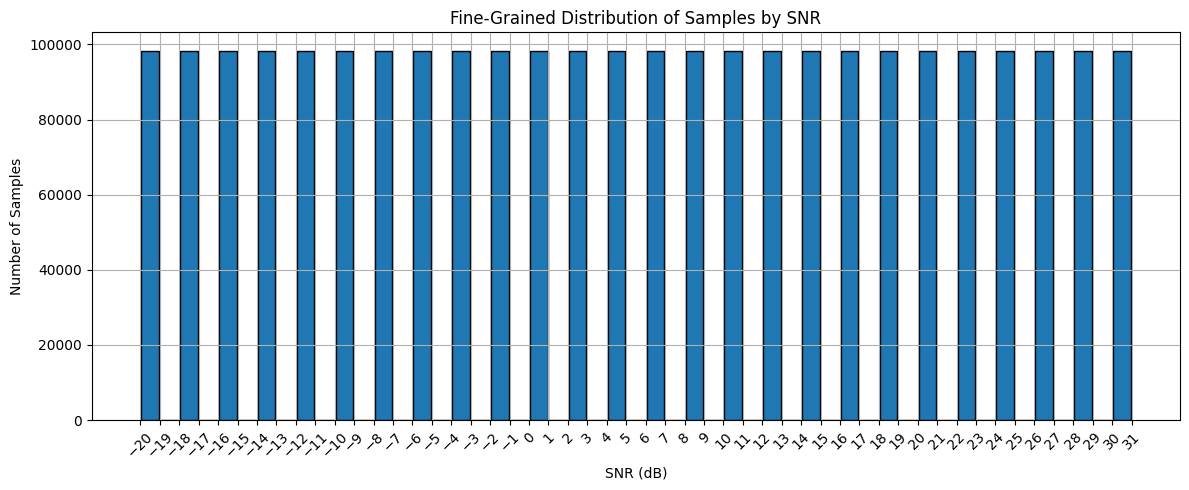

In [ ]:
# Squeeze SNR array in case it has shape (N, 1)
snr_vals = np.squeeze(snr)

# Define finer bin edges, e.g., -20 to +20 in 1 dB steps
bin_edges = np.arange(-20, 32, 1)  # from -20 to +20 (inclusive)

# Create histogram
plt.figure(figsize=(12, 5))
plt.hist(snr_vals, bins=bin_edges, edgecolor='black', rwidth=0.9)

# Labeling
plt.xlabel("SNR (dB)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Samples by SNR")
plt.xticks(bin_edges, rotation=45)  # tick for each bin
plt.grid(True)
plt.tight_layout()
plt.show()

Next, I plot number of samples per modulation

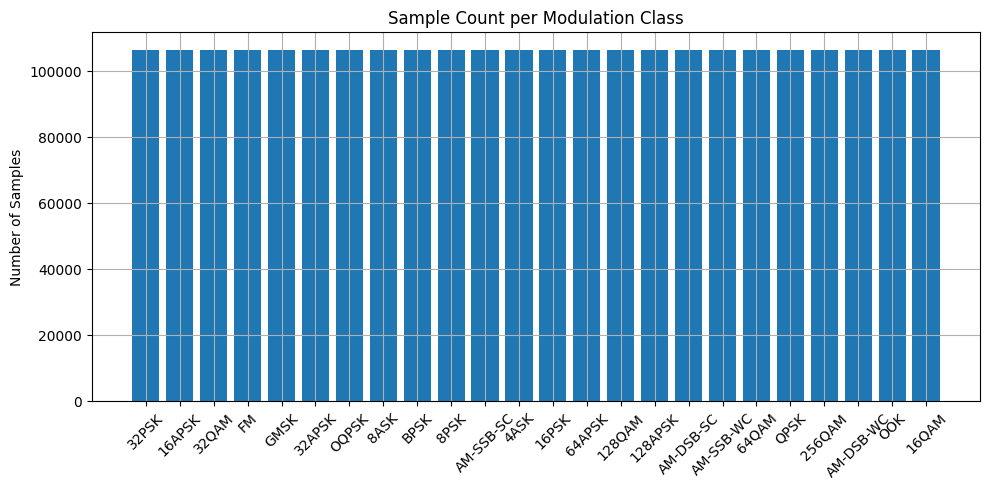

In [37]:
mod_counts = np.sum(y, axis=0)  # sum over one-hot labels
plt.figure(figsize=(10, 5))
plt.bar(classes, mod_counts)
plt.xticks(rotation=45)
plt.ylabel("Number of Samples")
plt.title("Sample Count per Modulation Class")
plt.grid(True)
plt.tight_layout()
plt.show()


The following is a 2D heat map that combines the last two histograms. A 3D plot could be helpful as well but does not the 3D bars did not look esthetically pleasing.

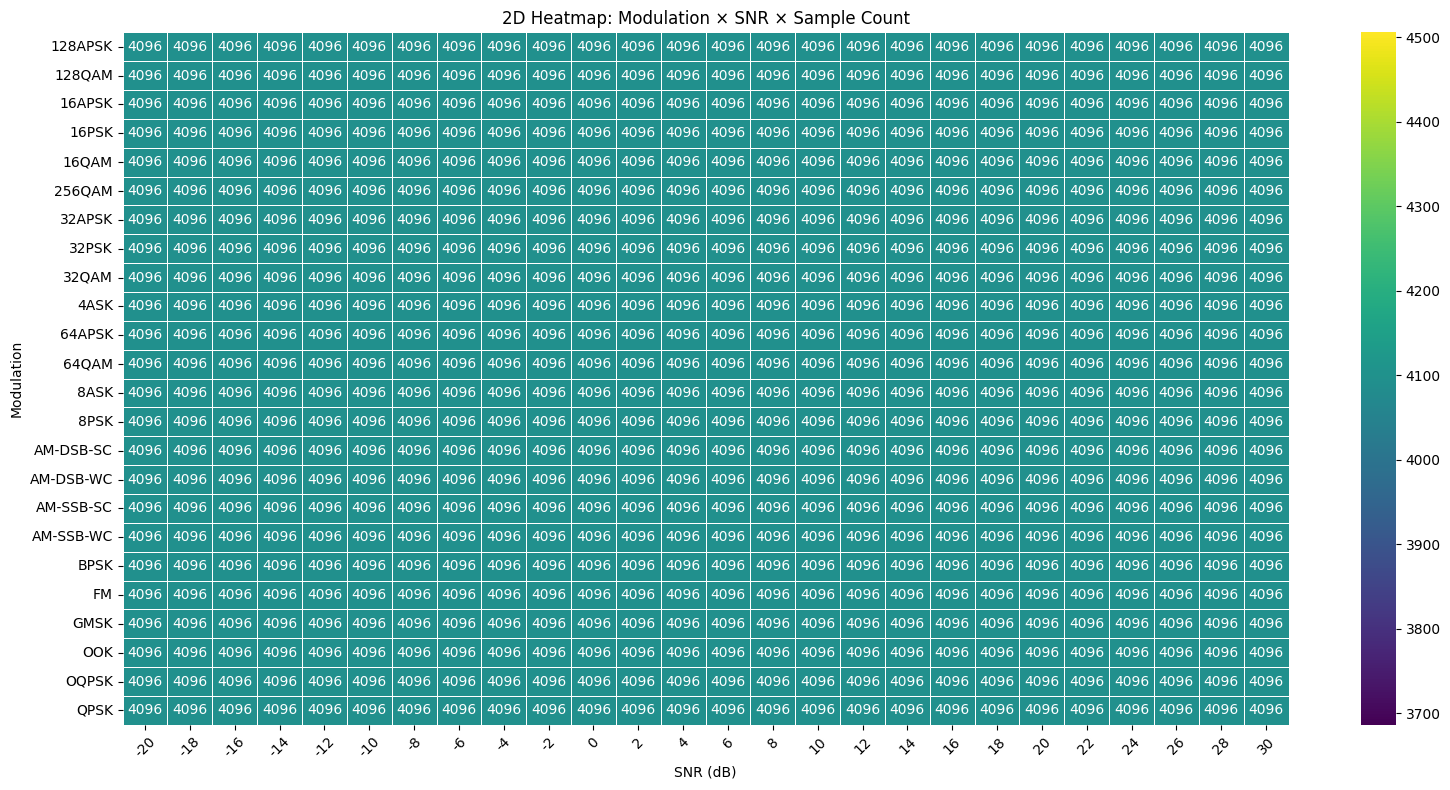

In [46]:
# Step 1: Decode labels and flatten SNR
mod_indices = y.argmax(axis=1)
snr_vals = np.squeeze(snr).astype(int)

# Step 2: Map indices to modulation names
mod_names = np.array(classes)[mod_indices]

# Step 3: Create DataFrame for grouping
df = pd.DataFrame({
    "Modulation": mod_names,
    "SNR": snr_vals
})

# Step 4: Pivot table — rows = modulation, columns = SNR, values = count
pivot = df.pivot_table(index="Modulation", columns="SNR", aggfunc="size", fill_value=0)

# Step 5: Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pivot, cmap="viridis", annot=True, fmt="d", linewidths=0.5)

plt.title("2D Heatmap: Modulation × SNR × Sample Count")
plt.xlabel("SNR (dB)")
plt.ylabel("Modulation")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
